In [2]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

# proper labeling of plots
from matplotlib.ticker import EngFormatter

In [3]:
def random_symbols(A, N):
    """generate random symbols from the constellation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [4]:
from scipy import special
def Q(x):
    """Gaussian error function"""
    return 0.5*special.erfc(x/np.sqrt(2))

In [5]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [6]:
def serial_to_parallel(syms, M):
    """Convert a vector of symbols to a matrix with trailing dimension M
    
    Inputs:
    * syms - vector of information symbols
    * M - block size

    Returns:
    matrix of dimensions (*,M)
    """
    L = len(syms)
    K = L % M      # L mod M

    if K != 0:
        syms = np.append(syms, np.zeros(M-K))  # zero-padding

    return np.reshape(syms, (-1, M))           # -1 means: figure out first dimension

In [7]:
def map_to_subcarriers(block_syms, active_sc):
    """Map a matrix of symbols to active subcarriers
    
    Inputs:
    * block_syms - matrix of symbols, dimension (*,N)
    * active_sc - length N vector that marks active subcarries with 1's 

    Returns:
    matrix of dimension (*,N)
    """
    # make an array to hold the result; figure out dimensions and data type
    N = len(active_sc)
    L = block_syms.shape[0]
    res = np.zeros((L,N), dtype=syms.dtype)

    res[:,np.equal(active_sc, 1)] = block_syms

    return res

In [8]:
def idft(block_sc):
    """inverse DFT of matrix of symbols
    
    Inputs:
    block_sc - matrix of symbols (and empty subcarriers)

    Returns:
    matrix of the same size as the input
    """
    N_FFT = block_sc.shape[1]
    # print(N_FFT)
    return np.fft.ifft(block_sc) * np.sqrt(N_FFT)

In [9]:
def insert_cyclic_prefix(block_sig, N_CP):
    """Insert cyclic prefix
    
    Inputs:
    block_sig - matrix of signal samples
    N_CP - length of cyclic prefix in samples

    Returns:
    signal matrix with cyclic prefix inserted; second dimension increases by N_CP
    """
    if N_CP > 0:
        return np.append(block_sig[:,-N_CP:], block_sig, axis=1)
    else:
        return block_sig

In [10]:
def ser_qpsk_exact(x):
    exact_qpsk_ser = 2*Q(np.sqrt(x)) - Q(np.sqrt(x))**2
    return exact_qpsk_ser

In [11]:
def parallel_to_serial(block_sig):
    """convert a matrix of signal samples into a vector
    
    Inputs:
    block_sig - matrix of signal samples

    Returns:
    vector of signal samples
    """
    return np.reshape(block_sig, -1)  # -1 means: figure out how many samples

In [12]:
def strip_cyclic_prefix(block_sig_cp, N_CP):
    """remove the leading N_CP samples from each signal block
    
    Inputs:
    block_sig_cp - matrix of signal blocks with cyclic prefix
    N_CP - length of cyclic prefix in samples

    Returns:
    matrix of signal blocks without cyclic prefix
    """
    return block_sig_cp[:, N_CP:]

In [13]:
def dft(block_sig):
    """ DFT of matrix of signal blocks
    
    Inputs:
    block_sig - matrix of signals

    Returns:
    matrix of the same size as the input
    """
    N_FFT = block_sig.shape[1]
    return np.fft.fft(block_sig) * 1/np.sqrt(N_FFT)

In [14]:
def remove_inactive_subcarriers(block_sc, active_sc):
    """Extract symbols from active subcarriers
    
    Inputs:
    block_sc - matrix of symbols and empty subcarriers
    active_sc - length N vector that marks active subcarries with 1's 

    Returns:
    Matrix of symbols without empty subcarriers
    """
    return block_sc[:,np.equal(active_sc, 1)]

In [15]:
class OFDM_Transmitter():
    """OFDM transmitter class
    
    Parameters:
    N_CP - length of cyclic prefix
    active_sc - length N_FFT vector marking active subcarriers

    Example:
    # create a transmitter object
    tx = OFDM_Transmitter(N_CP, active_sc) 

    # pass symbols to tx object to generate signal
    sig = tx(syms)
    """
    def __init__(self, N_CP, active):
        self.N_CP = N_CP
        self.active = active
        self.N_FFT = len(active)

        self.M = int(np.sum(active))  # number of active subcarriers

    def __call__(self, syms):
        block_syms = serial_to_parallel(syms, self.M)
        block_sc = map_to_subcarriers(block_syms, self.active)
        block_sig = idft(block_sc)
        block_sig_cp = insert_cyclic_prefix(block_sig, self.N_CP)
        return parallel_to_serial(block_sig_cp)

In [16]:
class OFDM_Receiver():
    """OFDM receiver class
    
    Parameters:
    N_CP - length of cyclic prefix
    active_sc - length N_FFT vector marking active subcarriers

    Example:
    # create a receiver object
    rx = OFDM_Receiver(N_CP, active_sc) 

    # pass signal to rx object to recover symbols; 
    # number of symbols to receive must be provided, unless there was no zero padding.
    syms = rx(sig, N_syms)
    """
    def __init__(self, N_CP, active):
        self.N_CP = N_CP
        self.active = active
        self.N_FFT = len(active)

        self.M = np.sum(active)  # number of active subcarriers

    def __call__(self, sig, N_syms=None):
        block_sig_cp = serial_to_parallel(sig, self.N_FFT + self.N_CP)
        block_sig = strip_cyclic_prefix(block_sig_cp, self.N_CP)
        block_sc = dft(block_sig)
        block_syms = remove_inactive_subcarriers(block_sc, self.active)
        syms = parallel_to_serial(block_syms)

        if N_syms is None:
            N_syms = len(syms)

        return syms[:N_syms]

In [17]:
# Round-trip test without noise
N_syms = 10000

# 128 subcarriers with 96 of them occupied
N_FFT = 128
N_active = 96
active = np.ones(128)
active[N_active//2 : -N_active//2] = 0 # gap in the center (maps to band-edges)
N_CP = 6

# define a normalized QPSK constellation
A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) 

# generate random symbols
syms = random_symbols(A, N_syms)

# instantiate tx and rx objects
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

sig = tx(syms)
if np.allclose(rx(sig, N_syms), syms):
    print("all symbols received correctly")

all symbols received correctly


In [18]:
# parameters
# 128 subcarriers with 96 of them occupied
N_FFT = 128
N_active = 96
active = np.ones(128)
active[N_active//2 : -N_active//2] = 0 # gap in the center (maps to band-edges)
# print(active)
N_CP = 0
# N_CP = N_FFT // 4

# channel (AWGN)
SNR_dB = 10
SNR = 10**(SNR_dB/10)

A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
N = N_active * 64                    # number of symbols per OFDM burst

# simulation parameters
max_bursts = 1000
max_errors = 400
N_bursts = 0
N_errors = 0

# instantiate tx and rx
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

In [19]:
# the Monte Carlo loop
while N_bursts < max_bursts and N_errors < max_errors:
    # Transmitter
    sym = random_symbols(A, N)
    # print(len(sym))
    ss = tx(sym)
    # print(len(ss))
    # print(ss)
    # make sure that the signal has unit energy per symbol
    ss = ss * np.sqrt(N)/np.linalg.norm(ss)
    mag_ss = 1/len(sym) *np.sum(np.abs(ss)**2)
    # print("The Average energy of the entire signal has to be one", mag_ss)
    # Channel
    rr = ss + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
    # receiver
    Z = rx(rr)
    dec = MPE_decision_rule(Z, A) # Z[:N] trims extra samples from the filter transisent

    # update simulation statistics
    N_bursts += 1
    N_errors += np.sum(np.not_equal(dec, sym))
SNR_new = SNR * N_FFT/(N_CP+N_FFT)
print("Effective SNR is {:4.2f}dB".format(10*np.log10(SNR_new)))
print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, N_errors/(N*N_bursts)))
print("The exact value for the symbol error rate is: {:8.6f}".format(2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2))

Effective SNR is 10.00dB
Found 443 errors in 307200 symbols; estimated symbol error rate 0.001442
The exact value for the symbol error rate is: 0.001565


In [24]:
ser_sim = []
ser_exact = []
df_range = np.arange(-0.25, 0.252, 0.025)
z_out = []
for df in df_range:
    N_FFT = 128
    N_active = 96
    active = np.ones(128)
    active[N_active//2 : -N_active//2] = 0 # gap in the center (maps to band-edges)
    # print(active)
    # N_CP = 0
    N_CP = N_FFT // 4

    # channel (AWGN)
    SNR_dB = 10
    SNR = 10**(SNR_dB/10)

    A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
    N = N_active * 64                    # number of symbols per OFDM burst
    # simulation parameters
    max_bursts = 1000
    max_errors = 400
    N_bursts = 0
    N_errors = 0

    # instantiate tx and rx
    tx = OFDM_Transmitter(N_CP, active)
    rx = OFDM_Receiver(N_CP, active)
    # the Monte Carlo loop
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(A, N)
        # print(len(sym))
        ss = tx(sym)
        # print(len(ss))
        # print(ss)
        # make sure that the signal has unit energy per symbol
        ss = ss * np.sqrt(N)/np.linalg.norm(ss)
        mag_ss = 1/len(sym) *np.sum(np.abs(ss)**2)
        # print("The Average energy of the entire signal has to be one", mag_ss)
        # Channel
        # Apply frequency shift
        # rr = ss * np.exp(2j * np.pi * df / N_FFT * np.arange(len(ss)))
        # # Add noise
        # rr = rr + np.sqrt(0.5 / SNR) * (np.random.randn(len(ss)) + 1j * np.random.randn(len(ss)))

        rr = (ss * np.exp(2j*np.pi * df/N_FFT * (np.arange(len(ss))-len(ss)/2)) + # <-- frequency offset with zero average phase
              np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss))))
        # receiver
        Z = rx(rr)
        
        dec = MPE_decision_rule(Z, A) # Z[:N] trims extra samples from the filter transisent

        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))
    z_out.append(Z)
    ser_sim.append(N_errors/(N*N_bursts))
    ser_exact.append(2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2)
    SNR_new = SNR * N_FFT/(N_CP+N_FFT)
    print("Effective SNR is {:4.2f}dB".format(10*np.log10(SNR_new)))
    print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, N_errors/(N*N_bursts)))
    print("The exact value for the symbol error rate is: {:8.6f}".format(2*Q(np.sqrt(SNR_new)) - Q(np.sqrt(SNR_new))**2))

Effective SNR is 9.03dB
Found 4590 errors in 6144 symbols; estimated symbol error rate 0.747070
The exact value for the symbol error rate is: 0.004672
Effective SNR is 9.03dB
Found 4576 errors in 6144 symbols; estimated symbol error rate 0.744792
The exact value for the symbol error rate is: 0.004672
Effective SNR is 9.03dB
Found 4597 errors in 6144 symbols; estimated symbol error rate 0.748210
The exact value for the symbol error rate is: 0.004672
Effective SNR is 9.03dB
Found 4617 errors in 6144 symbols; estimated symbol error rate 0.751465
The exact value for the symbol error rate is: 0.004672
Effective SNR is 9.03dB
Found 4584 errors in 6144 symbols; estimated symbol error rate 0.746094
The exact value for the symbol error rate is: 0.004672
Effective SNR is 9.03dB
Found 4597 errors in 6144 symbols; estimated symbol error rate 0.748210
The exact value for the symbol error rate is: 0.004672
Effective SNR is 9.03dB
Found 4612 errors in 6144 symbols; estimated symbol error rate 0.75065

/var/folders/7y/zn2wsyn90v971fl99gkffxdh0000gn/T/ipykernel_88419/918617400.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(df_range, ser_sim, 'ko', marker='o', linestyle='-')


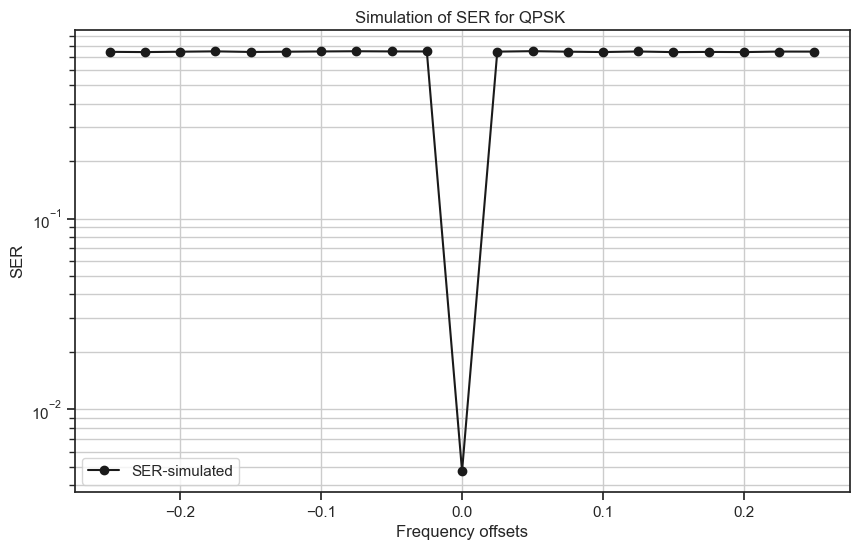

In [25]:
plt.figure(figsize=(10, 6))

# Plot SNR vs errors, with a logarithmic scale for the errors
plt.plot(df_range, ser_sim, 'ko', marker='o', linestyle='-')
# plt.plot(df_range, ser_sim2, 'ko', marker='o', linestyle='-')
# plt.plot(df_range, ser_exact, 'b', linestyle='--')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Frequency offsets')
plt.ylabel('SER')
plt.title('Simulation of SER for QPSK ')
plt.grid(True, which="both")  # Add gridlines for both major and minor ticks
plt.legend(['SER-simulated','SER-Exact' ])

# Show the plot
plt.show()


In [ ]:
plt.plot(np.real(z_out[3]), np.imag(z_out[3]), 'o')

plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')


plt.show()

In [130]:
#  3c
ser_sims = []
ser_exact = []
N_CP_range = [0,4,8,16,32]
z_out_sims = []
for n_cp in N_CP_range:
    df_range = np.arange(-0.02, 0.03, 0.01) 
    ser_sim = []
    z_out = []
    for df in df_range:
        N_FFT = 128
        N_active = 96
        active = np.ones(128)
        active[N_active//2 : -N_active//2] = 0 # gap in the center (maps to band-edges)
        # print(active)
        # N_CP = 0
        N_CP = n_cp

        # N_CP = N_FFT // n_cp

        # channel (AWGN)
        SNR_dB = 10
        SNR = 10**(SNR_dB/10)

        A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
        N = N_active * 64                    # number of symbols per OFDM burst
        # simulation parameters
        max_bursts = 1000
        max_errors = 400
        N_bursts = 0
        N_errors = 0

        # instantiate tx and rx
        tx = OFDM_Transmitter(N_CP, active)
        rx = OFDM_Receiver(N_CP, active)
        # the Monte Carlo loop
        while N_bursts < max_bursts and N_errors < max_errors:
            # Transmitter
            sym = random_symbols(A, N)
            # print(len(sym))
            ss = tx(sym)
            # print(len(ss))
            # print(ss)
            # make sure that the signal has unit energy per symbol
            ss = ss * np.sqrt(N)/np.linalg.norm(ss)
            mag_ss = 1/len(sym) *np.sum(np.abs(ss)**2)
            # print("The Average energy of the entire signal has to be one", mag_ss)
            # Channel
            # Apply frequency shift
            rr = ss * np.exp(2j * np.pi * df / N_FFT * np.arange(len(ss)))
            # Add noise
            rr = rr + np.sqrt(0.5 / SNR) * (np.random.randn(len(ss)) + 1j * np.random.randn(len(ss)))
            # receiver
            Z = rx(rr)
            
            dec = MPE_decision_rule(Z, A) # Z[:N] trims extra samples from the filter transisent

            # update simulation statistics
            N_bursts += 1
            N_errors += np.sum(np.not_equal(dec, sym))
        z_out.append(Z)
        ser_sim.append(N_errors/(N*N_bursts))
        ser_exact.append(2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2)
        SNR_new = SNR * N_FFT/(N_CP+N_FFT)
        # print("Effective SNR is {:4.2f}dB".format(10*np.log10(SNR_new)))
        # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, N_errors/(N*N_bursts)))
        # print("The exact value for the symbol error rate is: {:8.6f}".format(2*Q(np.sqrt(SNR_new)) - Q(np.sqrt(SNR_new))**2))
    ser_sims.append(ser_sim)
    z_out_sims.append(z_out)

In [131]:
ser_sims

[[np.float64(0.7014973958333334),
  np.float64(0.8064778645833334),
  np.float64(0.0015405462693798449),
  np.float64(0.80517578125),
  np.float64(0.7083333333333334)],
 [np.float64(0.7177734375),
  np.float64(0.8118489583333334),
  np.float64(0.0018601190476190475),
  np.float64(0.8123372395833334),
  np.float64(0.7150065104166666)],
 [np.float64(0.72119140625),
  np.float64(0.8193359375),
  np.float64(0.0022406684027777776),
  np.float64(0.81396484375),
  np.float64(0.7255859375)],
 [np.float64(0.74267578125),
  np.float64(0.826171875),
  np.float64(0.0028483072916666665),
  np.float64(0.8264973958333334),
  np.float64(0.7425130208333334)],
 [np.float64(0.7666015625),
  np.float64(0.8445638020833334),
  np.float64(0.004633246527777778),
  np.float64(0.8426106770833334),
  np.float64(0.7696940104166666)]]

In [132]:
len(z_out_sims[0][2])

6144

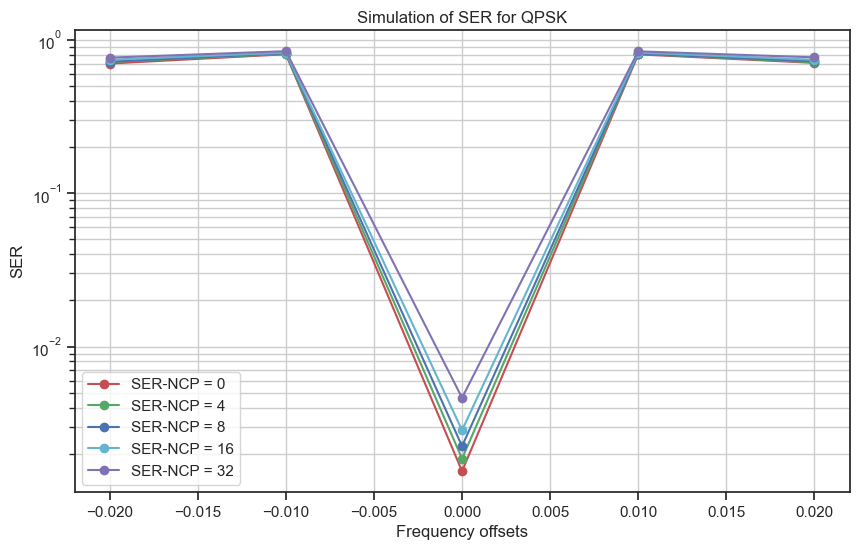

In [133]:
plt.figure(figsize=(10, 6))

# Define different colors and legends
colors = ['r', 'g', 'b', 'c', 'm']  # List of colors for each plot
legends = ['SER-NCP = 0', 'SER-NCP = 4', 'SER-NCP = 8 ', 'SER-NCP = 16', 'SER-NCP = 32']  # Update legends accordingly

# Plot SNR vs errors, with a logarithmic scale for the errors
for i in range(5):
    plt.plot(df_range, ser_sims[i], color=colors[i], marker='o', linestyle='-', label=legends[i])

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Frequency offsets')
plt.ylabel('SER')
plt.title('Simulation of SER for QPSK')
plt.grid(True, which="both")  # Add gridlines for both major and minor ticks
plt.legend()  # Display legend with updated labels

# Show the plot
plt.show()

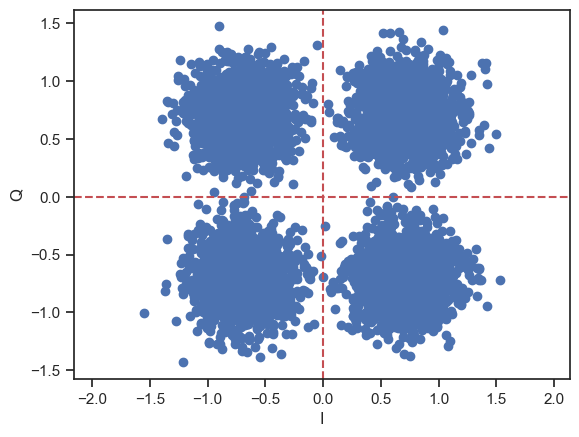

In [128]:
plt.plot(np.real(z_out_sims[0][2]), np.imag(z_out_sims[][2]), 'o')

plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')


plt.show()

In [166]:
#  3d
ser_sims = []
ser_exact = []
N_active_range = [128,256,512]
z_out_sims = []
for n_active in N_active_range:
    df_range = np.arange(-0.02, 0.03, 0.01) 
    ser_sim = []
    z_out = []
    for df in df_range:
        N_FFT = 128
        N_active = 96
        active = np.ones(n_active)
        active[N_active//2 : -N_active//2] = 0 # gap in the center (maps to band-edges)
        # print(active)
        N_CP = 0

        N_CP = 32

        # N_CP = N_FFT // 8

        # channel (AWGN)
        SNR_dB = 10
        SNR = 10**(SNR_dB/10)

        A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
        N = N_active * 64                    # number of symbols per OFDM burst
        # simulation parameters
        max_bursts = 1000
        max_errors = 400
        N_bursts = 0
        N_errors = 0

        # instantiate tx and rx
        tx = OFDM_Transmitter(N_CP, active)
        rx = OFDM_Receiver(N_CP, active)
        # the Monte Carlo loop
        while N_bursts < max_bursts and N_errors < max_errors:
            # Transmitter
            sym = random_symbols(A, N)
            # print(len(sym))
            ss = tx(sym)
            # print(len(ss))
            # print(ss)
            # make sure that the signal has unit energy per symbol
            ss = ss * np.sqrt(N)/np.linalg.norm(ss)
            mag_ss = 1/len(sym) *np.sum(np.abs(ss)**2)
            # print("The Average energy of the entire signal has to be one", mag_ss)
            # Channel
            # Apply frequency shift
            rr = ss * np.exp(2j * np.pi * df / N_FFT * np.arange(len(ss)))
            # Add noise
            rr = rr + np.sqrt(0.5 / SNR) * (np.random.randn(len(ss)) + 1j * np.random.randn(len(ss)))
            # receiver
            Z = rx(rr)
            
            dec = MPE_decision_rule(Z, A) # Z[:N] trims extra samples from the filter transisent

            # update simulation statistics
            N_bursts += 1
            N_errors += np.sum(np.not_equal(dec, sym))
        z_out.append(Z)
        ser_sim.append(N_errors/(N*N_bursts))
        ser_exact.append(2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2)
        SNR_new = SNR * N_FFT/(N_CP+N_FFT)
        # print("Effective SNR is {:4.2f}dB".format(10*np.log10(SNR_new)))
        # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, N_errors/(N*N_bursts)))
        # print("The exact value for the symbol error rate is: {:8.6f}".format(2*Q(np.sqrt(SNR_new)) - Q(np.sqrt(SNR_new))**2))
    ser_sims.append(ser_sim)
    z_out_sims.append(z_out)

In [167]:
len(z_out_sims)

3

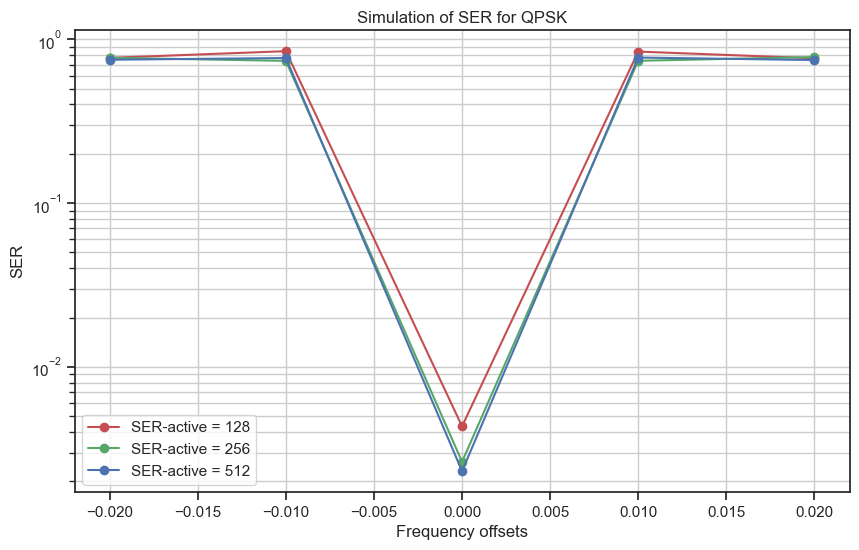

In [168]:
plt.figure(figsize=(10, 6))

# Define different colors and legends
colors = ['r', 'g', 'b', 'c', 'm']  # List of colors for each plot
legends = ['SER-active = 128', 'SER-active = 256', 'SER-active = 512']  # Update legends accordingly

# Plot SNR vs errors, with a logarithmic scale for the errors
for i in range(3):
    plt.plot(df_range, ser_sims[i], color=colors[i], marker='o', linestyle='-', label=legends[i])

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Frequency offsets')
plt.ylabel('SER')
plt.title('Simulation of SER for QPSK')
plt.grid(True, which="both")  # Add gridlines for both major and minor ticks
plt.legend()  # Display legend with updated labels

# Show the plot
plt.show()